# Glassdoor HR Review Detector

# 1. Theory

- The kinds of words that genuine employees use in glassdoor review is different from the one used by HR.
- So my theory is that I can use AI to distinguist between these two kind of reviews.
- This will be achived using embeddings. An embedding is a coversion of natural language to vectors. Vectors of similar words are close to each other. My theory is that one or more regions of of the vector space are more of the human resources kind while other regions are more of the genuine employee kinds.
- My goal is to train a neural network to identify regions in the vector space that are "hr"-ish vs. regions that are "genuine"-ish. Based on this, given a review text, the network will be able to predict if the review was written by HR or not.


- Training data consists of pros, cons, overall review, sounds like hr
- pros, cons represented as vector embeddings using openai api

> **NOTE**: How is the `sounds_like_hr` field set in the training data? The answer is that I set it based on my gut instinct! **Please do not take this project seriously**, it's just an excuse to try out machine learning algorithms. For context: I used Glassdoor in the past and suspected some reviews were written by HR; either because they would say there are no cons or they would pander to the company like 'you have to work late, but it's worth it'. I thought it would be a fun project to build an AI that could detect this based on my instinct rather than emperical data.

## 1.1 Setup

In [1]:
import csv
import tempfile
import numpy as np
from IPython.display import display, HTML
from utils.utils import load_csv_as_dictionary, array_of_dictionaries_to_csv_string
from sklearn.model_selection import train_test_split
from langchain_openai import OpenAIEmbeddings
from langchain_community.document_loaders.csv_loader import CSVLoader
from langchain_chroma import Chroma
import pandas as pd
from openai import OpenAI
import ast

openaiClient = OpenAI()

In [2]:
# 1. load csv as array of objects 
training_data = load_csv_as_dictionary(csv_filename='training-data/glassdoor-reviews-main.csv')

In [43]:
import concurrent.futures
import os

def file_exists_and_not_empty(file_path):
    return os.path.isfile(file_path) and os.path.getsize(file_path) > 0

def get_embedding(text, model="text-embedding-3-small"):
    text = text.replace("\n", "")
    return openaiClient.embeddings.create(input=[text], model=model, dimensions=256).data[0].embedding

def add_embeddings_to_data(data={}):
    def process_item(item):
        item['sounds_like_hr'] = int(item['sounds_like_hr']) == 1
        item['pros_embedding'] = get_embedding(item['pros'])
        item['cons_embedding'] = get_embedding(item['cons'])
        return item
    
    with concurrent.futures.ThreadPoolExecutor() as executor:
        results = list(executor.map(process_item, data))
    
    return pd.DataFrame(results)

EMBEDDINGS_CSV = "./embeddings/full_training_data.csv"
if file_exists_and_not_empty(EMBEDDINGS_CSV):
    training_df = pd.read_csv(EMBEDDINGS_CSV)
    training_df['pros_embedding'] = training_df['pros_embedding'].apply(lambda x: np.array(ast.literal_eval(x)))
    training_df['cons_embedding'] = training_df['cons_embedding'].apply(lambda x: np.array(ast.literal_eval(x)))
else:
    training_df = add_embeddings_to_data(data=training_data)
    training_df.to_csv(EMBEDDINGS_CSV)

In [4]:
review_genuity_dict = {item["empReview_id"]: item["sounds_like_hr"] for item in training_data}

# 2. Visualising the Embeddings

We will compare the embeddings of pros and cons of genuine and HR written reviews to see their relative position in the embedding vector space. 

Given my observation that either:
- HR written cons claim there aren't any e.g. "no cons", "Can't think of any, really.", "nothing to mention everything is going great"
- HR written cons tend to be PR friendly e.g. "you'll need to work late but that is expected for a startup"
Then
- The embedding of HR cons will have some specific clusters, corresponding to e.g. "no cons" and/or "late sittings"
- The embedding of HR cons will overlap with pros.

First, let's see what embeddings look like

In [37]:
training_df[training_df['sounds_like_hr'] == False]['pros_embedding']

(283,)

In [53]:
genuine_pros_matrix = np.array(training_df[training_df['sounds_like_hr'] == False]['pros_embedding'].tolist())
genuine_cons_matrix = np.array(training_df[training_df['sounds_like_hr'] == False]['cons_embedding'].tolist())
hr_pros_matrix = np.array(training_df[training_df['sounds_like_hr'] == True]['pros_embedding'].tolist())
hr_cons_matrix = np.array(training_df[training_df['sounds_like_hr'] == True]['cons_embedding'].tolist())
print(f"Geninuine Pros Embedding Shape: {genuine_pros_matrix.shape}")
print(f"Geninuine Cons Embedding Shape: {genuine_cons_matrix.shape}")
print(f"HR Pros Embedding Shape: {hr_pros_matrix.shape}")
print(f"HR Cons Embedding Shape: {hr_cons_matrix.shape}")

Geninuine Pros Embedding Shape: (283, 256)
Geninuine Cons Embedding Shape: (283, 256)
HR Pros Embedding Shape: (68, 256)
HR Cons Embedding Shape: (68, 256)


## 2.1 Principal Component Analysis

We can see here that each review has 256 parameters. In order to visualise the relative position of embeddings, we will need to perform principal component analysis


In [54]:
from sklearn.decomposition import PCA

# Loading the PCA algorithm
pca_2 = PCA(n_components=2)
# Let's fit the data. We do not need to scale it, since sklearn's implementation already handles it.
pca_2.fit(genuine_pros_matrix)
print(f"Explained Variance Ratio: {pca_2.explained_variance_ratio_}")

genuine_pros_2d = pca_2.transform(genuine_pros_matrix)
genuine_cons_2d = pca_2.transform(genuine_cons_matrix)
hr_pros_2d = pca_2.transform(hr_pros_matrix)
hr_cons_2d = pca_2.transform(hr_cons_matrix)
print(genuine_pros_2d.shape)
print(genuine_cons_2d.shape)
print(hr_pros_2d.shape)
print(hr_cons_2d.shape)

Explained Variance Ratio: [0.05844204 0.05676322]
(283, 2)
(283, 2)
(68, 2)
(68, 2)


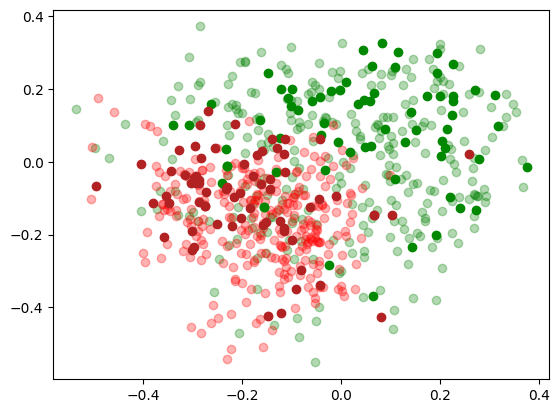

In [55]:
import matplotlib.pyplot as plt
import matplotlib

xgp = [x for x,y in genuine_pros_2d]
ygp = [y for x,y in genuine_pros_2d]
xgc = [x for x,y in genuine_cons_2d]
ygc = [y for x,y in genuine_cons_2d]

xhp = [x for x,y in hr_pros_2d]
yhp = [y for x,y in hr_pros_2d]
xhc = [x for x,y in hr_cons_2d]
yhc = [y for x,y in hr_cons_2d]

plt.scatter(xgp, ygp, c='green', alpha=0.3)
plt.scatter(xgc, ygc, c='red', alpha=0.3)
plt.scatter(xhp, yhp, c='#008800')
plt.scatter(xhc, yhc, c='#b22222')

*Note: While researching, I came across something called [TSNE](https://cookbook.openai.com/examples/visualizing_embeddings_in_2d). Saving it here to study more about it later.*

## Neural Network

In [56]:
import logging
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras import Sequential
from tensorflow.keras.losses import MeanSquaredError, BinaryCrossentropy
from tensorflow.keras.activations import sigmoid

logging.getLogger("tensorflow").setLevel(logging.ERROR)
tf.autograph.set_verbosity(0)

In [57]:
m = training_df.shape[0]
x = np.zeros((m, 513))
y = np.zeros((m,1))
for i in range(m):
    item = training_df.iloc[i]
    x[i, 0] = float(item['overall_rating'])  # First element is the rating
    x[i, 1:257] = item['pros_embedding']  # Next 256 elements are the pros embeddings
    x[i, 257:] = item['cons_embedding']  # Last 256 elements are the cons embeddings
    y[i,0] = item['sounds_like_hr']
print(x.shape)

(351, 513)


In [58]:
# 2. use scikit learn to split into training and test set?
x_train,y_train, x_cv,y_cv = train_test_split(x,y, test_size=0.40, random_state=1)
print(f"Training Set Shape: {x_train.shape}, {y_train.shape}")
print(f"Validation & Test Set Shape: {x_cv.shape}, {y_cv.shape}")

Training Set Shape: (210, 513), (141, 513)
Validation & Test Set Shape: (210, 1), (141, 1)
